In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# =====================================================
# 1️⃣ 데이터 로드
# =====================================================
csv_path = "new_flight_weather_merged.csv"
df = pd.read_csv(csv_path)

print("✅ CSV 로드 완료")
print("전체 행 수:", len(df))

C:\Users\Admin\AppData\Local\Temp\ipykernel_3332\729722976.py:5: DtypeWarning: Columns (29,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


✅ CSV 로드 완료
전체 행 수: 2843934


In [3]:
# =====================================================
# 2️⃣ 상태 == '지연' 데이터만 사용
# -----------------------------------------------------
# ✔ 지연시간 회귀는 '지연이 발생한 항공편'만 의미가 있음
# ✔ 정상/결항/회항 데이터는 회귀 대상이 아님
# =====================================================
reg_df = df[df["상태"] == "지연"].copy()
print("⏱ 상태=지연 데이터 수:", len(reg_df))

⏱ 상태=지연 데이터 수: 481449


In [4]:
# =====================================================
# 3️⃣ 지연_분 분포 확인 (정제 전)
# -----------------------------------------------------
# ✔ 데이터 이상치/결측치 여부 파악 목적
# =====================================================
print("📊 정제 전 지연_분 분포")
print(reg_df["지연_분"].describe())

📊 정제 전 지연_분 분포
count    481449.000000
mean         57.659744
std          43.249644
min       -1414.000000
25%          36.000000
50%          46.000000
75%          65.000000
max        1391.000000
Name: 지연_분, dtype: float64


In [5]:
# =====================================================
# 4️⃣ 지연_분 정제
# -----------------------------------------------------
# ✔ y(target)에 NaN이 있으면 모델 학습 불가
# ✔ 음수 지연은 논리적으로 불가능
# =====================================================

# ❗ 지연_분 NaN 제거 (가장 중요)
reg_df = reg_df[reg_df["지연_분"].notna()]

# ❗ 음수 제거
reg_df = reg_df[reg_df["지연_분"] >= 0].copy()

print("📊 음수 + NaN 제거 후 지연_분 분포")
print(reg_df["지연_분"].describe())

📊 음수 + NaN 제거 후 지연_분 분포
count    480981.000000
mean         57.810963
std          41.798592
min           0.000000
25%          36.000000
50%          46.000000
75%          65.000000
max        1391.000000
Name: 지연_분, dtype: float64


In [6]:
# =====================================================
# 5️⃣ 지연시간 상한 컷
# -----------------------------------------------------
# ✔ 360분(6시간) 이상은 이벤트성 지연
# ✔ 회귀 모델 안정화를 위해 상한 적용
# =====================================================
MAX_DELAY = 360
reg_df = reg_df[reg_df["지연_분"] <= MAX_DELAY].copy()

print("📊 상한 컷 후 지연_분 분포")
print(reg_df["지연_분"].describe())


📊 상한 컷 후 지연_분 분포
count    479872.000000
mean         56.778833
std          35.039417
min           0.000000
25%          36.000000
50%          46.000000
75%          64.000000
max         360.000000
Name: 지연_분, dtype: float64


In [7]:
# =====================================================
# 6️⃣ Feature 정의
# -----------------------------------------------------
# ✔ 분류 모델과 동일한 입력 사용
# ✔ 기상 + 시간 + 공항 정보
# =====================================================

# 🔢 수치형 변수
num_cols = [
    "기온(°C)",
    "풍속_ms",
    "dep_hour",
    "dep_weekday",
    "is_weekend"
]

# 🏷 범주형 변수
cat_cols = [
    "공항명",
    "출발지",
    "도착지",
    "flight_type"
]

# 실제 존재하는 컬럼만 사용
num_cols = [c for c in num_cols if c in reg_df.columns]
cat_cols = [c for c in cat_cols if c in reg_df.columns]

X_cols = num_cols + cat_cols

In [8]:
# =====================================================
# 7️⃣ 시간 기준 Train / Test 분리
# -----------------------------------------------------
# ✔ 미래 정보 누수 방지
# ✔ 실제 운영 상황과 동일한 분리 방식
# =====================================================
reg_df["departure_datetime"] = pd.to_datetime(reg_df["departure_datetime"])
reg_df = reg_df.sort_values("departure_datetime")

split_date = reg_df["departure_datetime"].quantile(0.8)

train_df = reg_df[reg_df["departure_datetime"] <= split_date]
test_df  = reg_df[reg_df["departure_datetime"] > split_date]

X_train = train_df[X_cols]
y_train = train_df["지연_분"]

X_test  = test_df[X_cols]
y_test  = test_df["지연_분"]

print("Train:", len(X_train), "Test:", len(X_test))

Train: 383897 Test: 95975


In [9]:
# =====================================================
# 8️⃣ y(target) NaN 사전 점검 및 제거
# -----------------------------------------------------
# ✔ y에 NaN이 있으면 모델 학습 불가
# ✔ X와 y를 동시에 정제하여 인덱스 불일치 방지
# =====================================================
print("y_train NaN 수:", y_train.isna().sum())
print("y_test  NaN 수:", y_test.isna().sum())

train_mask = y_train.notna()
test_mask  = y_test.notna()

X_train = X_train.loc[train_mask]
y_train = y_train.loc[train_mask]

X_test  = X_test.loc[test_mask]
y_test  = y_test.loc[test_mask]

print("NaN 제거 후 Train:", len(X_train), "Test:", len(X_test))

y_train NaN 수: 0
y_test  NaN 수: 0
NaN 제거 후 Train: 383897 Test: 95975


In [10]:
# =====================================================
# 9️⃣ 전처리 파이프라인
# -----------------------------------------------------
# ✔ 수치형: 중앙값 대치
# ✔ 범주형: UNKNOWN + One-Hot Encoding
# =====================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


In [11]:
# =====================================================
# 🔟 Deep Learning Regression (MLP) - 전처리 동일 적용
# -----------------------------------------------------
# ✔ sklearn ColumnTransformer(preprocessor) 그대로 사용
# ✔ 희소행렬(one-hot) -> Dense 변환 (너무 넓으면 SVD로 축소 옵션)
# =====================================================
import numpy as np
import tensorflow as tf
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error, mean_squared_error

# (재현성)
np.random.seed(42)
tf.random.set_seed(42)

# 1) 전처리(동일) 적용
X_train_pp = preprocessor.fit_transform(X_train)
X_test_pp  = preprocessor.transform(X_test)

print("전처리 후 shape:", X_train_pp.shape)

# 2) 희소행렬 처리
USE_SVD_IF_WIDE = True      # 원-핫 특성이 너무 많으면 자동으로 SVD로 줄임
SVD_THRESHOLD = 20000       # 특성 개수 임계값
SVD_COMPONENTS = 512        # 축소 차원(필요시 조절)

if USE_SVD_IF_WIDE and X_train_pp.shape[1] > SVD_THRESHOLD:
    print(f"[INFO] 특성 개수({X_train_pp.shape[1]})가 커서 TruncatedSVD({SVD_COMPONENTS})로 축소합니다.")
    svd = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=42)
    X_train_pp = svd.fit_transform(X_train_pp)
    X_test_pp  = svd.transform(X_test_pp)
else:
    # sparse -> dense (메모리 큰 경우 주의)
    if hasattr(X_train_pp, "toarray"):
        X_train_pp = X_train_pp.toarray()
        X_test_pp  = X_test_pp.toarray()

X_train_pp = X_train_pp.astype(np.float32)
X_test_pp  = X_test_pp.astype(np.float32)

y_train_np = y_train.values.astype(np.float32)
y_test_np  = y_test.values.astype(np.float32)

print("학습 입력 shape:", X_train_pp.shape)

# 3) tf.data Dataset
BATCH_SIZE = 256

train_ds = tf.data.Dataset.from_tensor_slices((X_train_pp, y_train_np)) \
    .shuffle(min(len(X_train_pp), 20000), seed=42) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_pp, y_test_np)) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

# 4) 모델 정의
input_dim = X_train_pp.shape[1]

dl_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1),
])

dl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
]

# 5) 학습
history = dl_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=200,
    callbacks=callbacks,
    verbose=1,
)

# 6) 평가
y_pred_dl = dl_model.predict(X_test_pp, batch_size=BATCH_SIZE).reshape(-1)

print("📊 Deep Learning Regression (MLP)")
print("MAE :", mean_absolute_error(y_test_np, y_pred_dl))
print("RMSE:", np.sqrt(mean_squared_error(y_test_np, y_pred_dl)))


전처리 후 shape: (383897, 300)
학습 입력 shape: (383897, 300)
Epoch 1/200
1500/1500 [==============================] - 6s 3ms/step - loss: 1170.4867 - mae: 21.5000 - val_loss: 904.5497 - val_mae: 18.9923 - lr: 0.0010
Epoch 2/200
1500/1500 [==============================] - 5s 3ms/step - loss: 1083.5139 - mae: 20.7000 - val_loss: 913.4529 - val_mae: 17.8576 - lr: 0.0010
Epoch 3/200
1500/1500 [==============================] - 5s 3ms/step - loss: 1075.1334 - mae: 20.6149 - val_loss: 897.6638 - val_mae: 19.6081 - lr: 0.0010
Epoch 4/200
1500/1500 [==============================] - 5s 3ms/step - loss: 1064.0045 - mae: 20.5380 - val_loss: 902.6141 - val_mae: 19.9274 - lr: 0.0010
Epoch 5/200
1500/1500 [==============================] - 5s 3ms/step - loss: 1054.8445 - mae: 20.4581 - val_loss: 896.8320 - val_mae: 18.2463 - lr: 0.0010
Epoch 6/200
1500/1500 [==============================] - 5s 3ms/step - loss: 1043.9828 - mae: 20.3595 - val_loss: 886.0165 - val_mae: 18.7022 - lr: 0.0010
Epoch 7/200
1500

1500/1500 [==============================] - 5s 3ms/step - loss: 858.4385 - mae: 18.6559 - val_loss: 810.2368 - val_mae: 17.5568 - lr: 0.0010
Epoch 54/200
1500/1500 [==============================] - 5s 3ms/step - loss: 861.0667 - mae: 18.6691 - val_loss: 829.4415 - val_mae: 17.8761 - lr: 0.0010
Epoch 55/200
1500/1500 [==============================] - 5s 4ms/step - loss: 857.3692 - mae: 18.6227 - val_loss: 807.7026 - val_mae: 17.7880 - lr: 0.0010
Epoch 56/200
1500/1500 [==============================] - 5s 3ms/step - loss: 846.0698 - mae: 18.5206 - val_loss: 809.6576 - val_mae: 17.6820 - lr: 5.0000e-04
Epoch 57/200
1500/1500 [==============================] - 5s 4ms/step - loss: 842.4611 - mae: 18.5033 - val_loss: 819.1301 - val_mae: 17.9768 - lr: 5.0000e-04
Epoch 58/200
1500/1500 [==============================] - 5s 4ms/step - loss: 842.5610 - mae: 18.4944 - val_loss: 814.6663 - val_mae: 17.9398 - lr: 5.0000e-04
Epoch 59/200
1500/1500 [==============================] - 5s 4ms/step -

In [12]:
# # =====================================================
# # 1️⃣1️⃣ Log-Deep Learning Regression (선택)
# # -----------------------------------------------------
# # ✔ 지연시간 long-tail 대응: log1p로 학습 -> expm1로 복원
# # ✔ 마지막에 y_pred를 이 결과로 덮어써서 아래 결과표에 반영
# # =====================================================
# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # log 변환
# y_train_log = np.log1p(y_train_np)
# y_test_log  = np.log1p(y_test_np)

# BATCH_SIZE = 256

# train_ds_log = tf.data.Dataset.from_tensor_slices((X_train_pp, y_train_log)) \
#     .shuffle(min(len(X_train_pp), 20000), seed=42) \
#     .batch(BATCH_SIZE) \
#     .prefetch(tf.data.AUTOTUNE)

# test_ds_log = tf.data.Dataset.from_tensor_slices((X_test_pp, y_test_log)) \
#     .batch(BATCH_SIZE) \
#     .prefetch(tf.data.AUTOTUNE)

# # 모델(새로) - 구조 동일
# dl_model_log = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(X_train_pp.shape[1],)),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dense(1),
# ])

# dl_model_log.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss="mse",
#     metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
# )

# history_log = dl_model_log.fit(
#     train_ds_log,
#     validation_data=test_ds_log,
#     epochs=200,
#     callbacks=callbacks,
#     verbose=1,
# )

# # 예측(log) -> 복원
# y_pred_log = dl_model_log.predict(X_test_pp, batch_size=BATCH_SIZE).reshape(-1)
# y_pred = np.expm1(y_pred_log)  # ✅ 아래 결과표에 쓰일 최종 예측값

# print("📊 Log-Deep Learning Regression")
# print("MAE :", mean_absolute_error(y_test_np, y_pred))
# print("RMSE:", np.sqrt(mean_squared_error(y_test_np, y_pred)))


In [13]:
# =====================================================
# ✅ (추가) 시각화 실행 안정화: y_pred 변수 통일
# -----------------------------------------------------
# 이 노트북은 회귀(지연_분) 예측을 다루며,
# - 기본 MLP 예측값은 y_pred_dl 로 만들어집니다.
# - (선택) Log-MLP를 켜면 최종 예측값을 y_pred 로 덮어쓰도록 설계되어 있습니다.
#
# 그런데 아래 "1️⃣2️⃣ 학습 곡선 & 예측 산점도" 셀과
# "1️⃣3️⃣ 예측 결과 확인" 셀이 y_pred 를 사용하고 있어서,
# Log-MLP를 실행하지 않으면 NameError가 날 수 있습니다.
#
# ✅ 해결:
# - y_pred 가 이미 있으면 그대로 사용 (Log-MLP 등)
# - y_pred 가 없고 y_pred_dl 이 있으면 y_pred = y_pred_dl 로 맞춰줌
# =====================================================

import numpy as np

# 1) y_pred가 이미 있으면 그대로 둡니다 (예: Log-MLP 결과를 y_pred로 덮어쓴 경우)
if "y_pred" in globals():
    print("✅ y_pred가 이미 존재합니다. (기존 값을 그대로 사용)")
# 2) y_pred가 없으면, 기본 MLP 예측값(y_pred_dl)을 y_pred로 통일해줍니다.
elif "y_pred_dl" in globals():
    y_pred = np.asarray(y_pred_dl).reshape(-1)  # (n,1) -> (n,)
    print("✅ y_pred가 없어서 y_pred_dl을 y_pred로 복사했습니다. (기본 MLP 결과)")
else:
    # 둘 다 없으면, 아직 예측을 만들기 전이므로 안내만 출력
    print("⚠️ 아직 예측값이 없습니다. 먼저 Deep Learning Regression 셀(🔟)을 실행해 y_pred_dl을 만든 후 진행하세요.")

✅ y_pred가 없어서 y_pred_dl을 y_pred로 복사했습니다. (기본 MLP 결과)


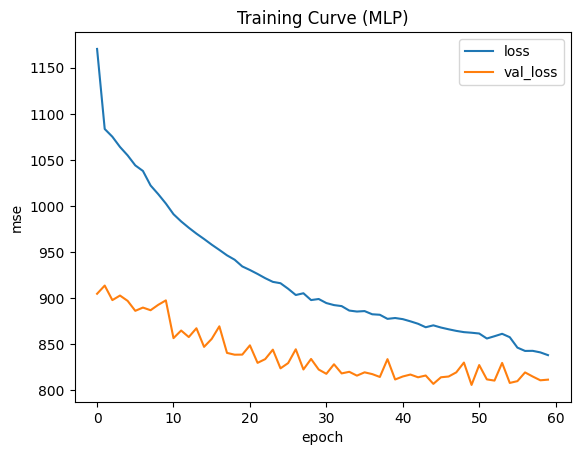

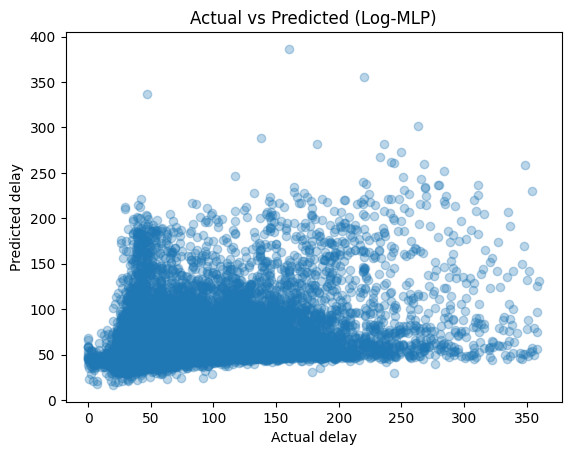

In [14]:
# =====================================================
# 1️⃣2️⃣ 학습 곡선 & 예측 산점도 (선택)
# =====================================================
import matplotlib.pyplot as plt

# 학습 곡선
plt.figure()
plt.plot(history.history.get("loss", []), label="loss")
plt.plot(history.history.get("val_loss", []), label="val_loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.title("Training Curve (MLP)")
plt.show()

# 예측 산점도 (로그 모델 결과 y_pred 사용)
plt.figure()
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.xlabel("Actual delay")
plt.ylabel("Predicted delay")
plt.title("Actual vs Predicted (Log-MLP)")
plt.show()


In [15]:
# ===============================
# ✅ 한글 폰트 깨짐 방지 설정
# ===============================
import matplotlib.pyplot as plt
import platform
import matplotlib.font_manager as fm

system = platform.system()

if system == "Windows":
    # Windows (대부분 Malgun Gothic 사용)
    plt.rcParams["font.family"] = "Malgun Gothic"

elif system == "Darwin":
    # macOS
    plt.rcParams["font.family"] = "AppleGothic"

else:
    # Linux (Colab / 서버)
    # 나눔고딕이 없을 경우 대비
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        plt.rcParams["font.family"] = "DejaVu Sans"

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

print(f"✅ 한글 폰트 설정 완료 ({system})")


✅ 한글 폰트 설정 완료 (Windows)


🔎 음수 예측 개수: 0 / 95,975


,metric,value
0,MAE,17.725452
1,RMSE,28.382114
2,R2,0.169433
3,MAPE(%),825264.160156


📌 절대오차 TOP 20 샘플


,기온(°C),풍속_ms,dep_hour,dep_weekday,is_weekend,공항명,출발지,도착지,flight_type,actual_delay_min,pred_delay_min,error,abs_error
26025,14.9,6.173328,17,4,0,인천,인천,덴파사(응우라 라이),국제,356.0,49.542191,-306.457825,306.457825
12400,5.8,4.115552,14,2,0,인천,인천,도쿄/나리타,국제,351.0,48.335171,-302.664825,302.664825
57355,25.0,2.572220,21,3,0,인천,인천,홍콩,국제,358.0,55.985340,-302.014648,302.014648
11762,7.2,6.687772,15,0,0,인천,인천,타이완 타오위안,국제,346.0,45.626110,-300.373901,300.373901
51227,27.5,7.202216,18,2,0,제주,제주,김포,국내,354.0,54.047615,-299.952393,299.952393
28364,12.4,2.572220,20,6,1,인천,인천,로스앤젤레스,국제,353.0,53.264141,-299.735870,299.735870
90200,11.9,3.086664,22,6,1,제주,제주,청주,국내,345.0,46.067238,-298.932770,298.932770
4523,-8.8,8.745548,18,4,0,인천,인천,클라크,국제,349.0,51.126289,-297.873718,297.873718
90160,11.1,0.500000,20,6,1,청주,청주,제주,국내,354.0,57.826378,-296.173615,296.173615
14447,2.3,8.231104,20,6,1,인천,인천,로스앤젤레스,국제,347.0,51.056686,-295.943298,295.943298


⚙️ plot_df 샘플링 적용: 95,975 -> 50,000


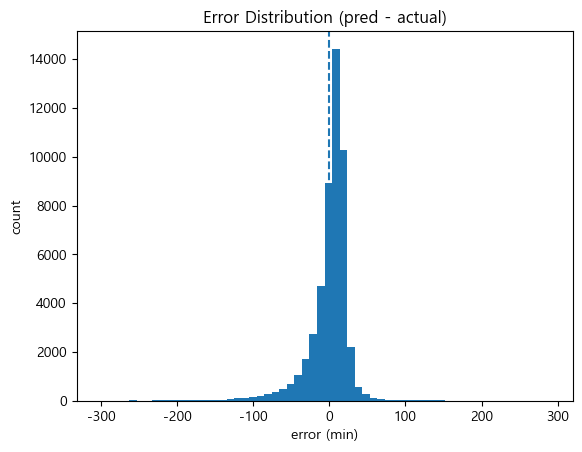

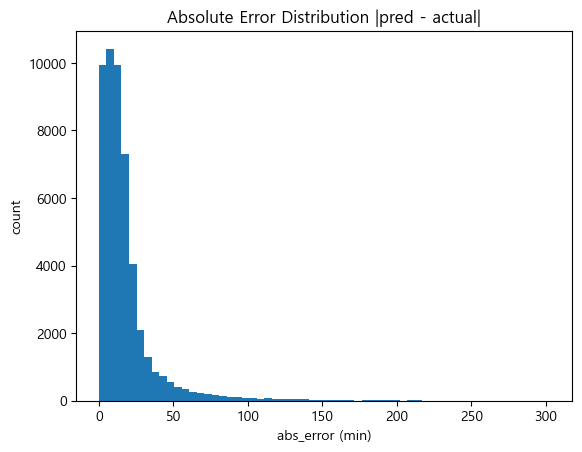

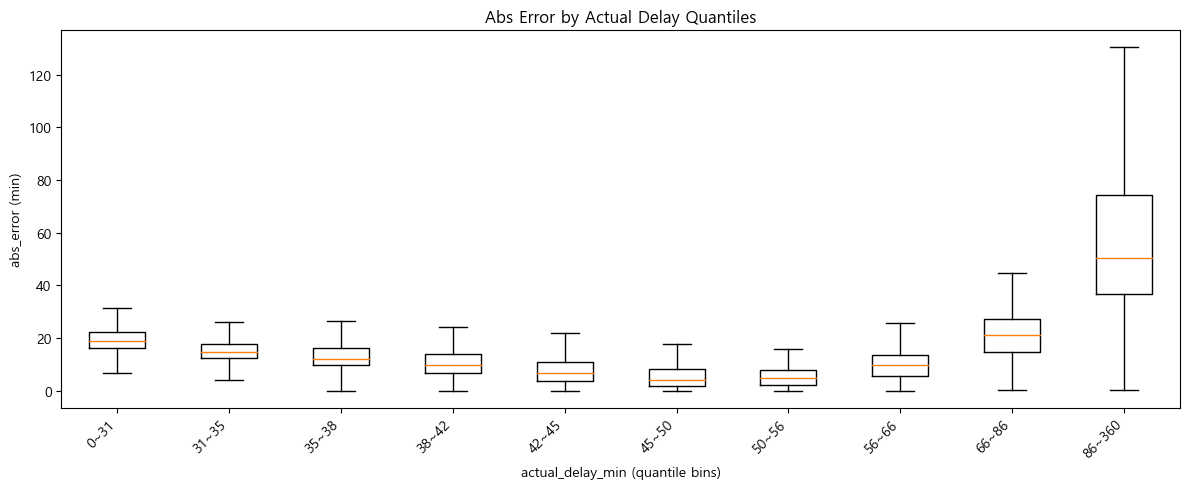

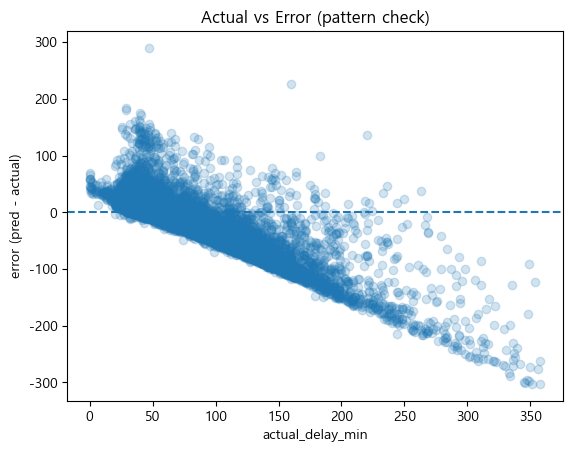

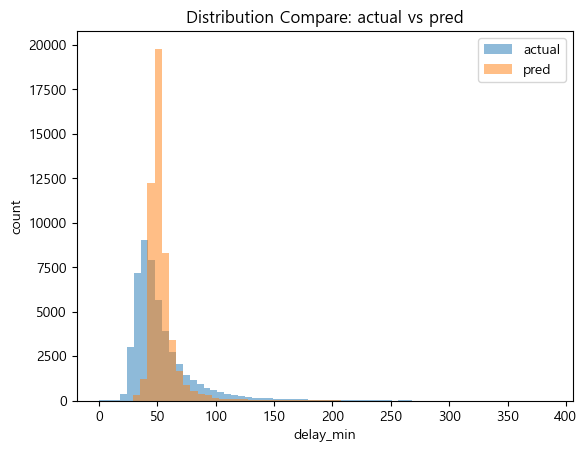

,mean_abs_error
dep_hour,
0,8.287745
1,14.651815
2,14.338980
3,23.724134
4,61.520908
5,68.500381
6,11.183464
7,11.334311
8,12.547400


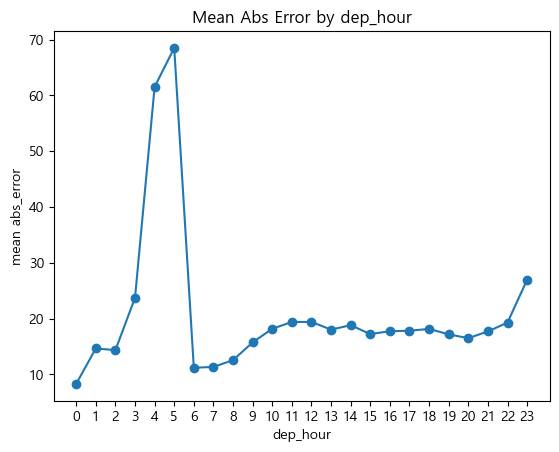

,mean_abs_error
dep_weekday,
0,17.191513
1,18.404667
2,18.388113
3,17.298433
4,17.937143
5,17.590694
6,17.262171


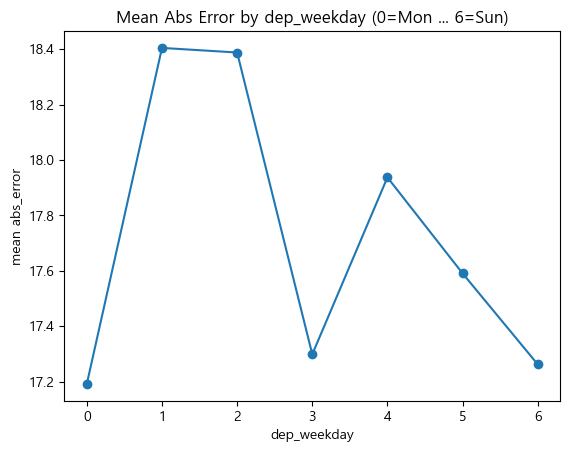

,mean_abs_error
is_weekend,
0,17.832678
1,17.429739


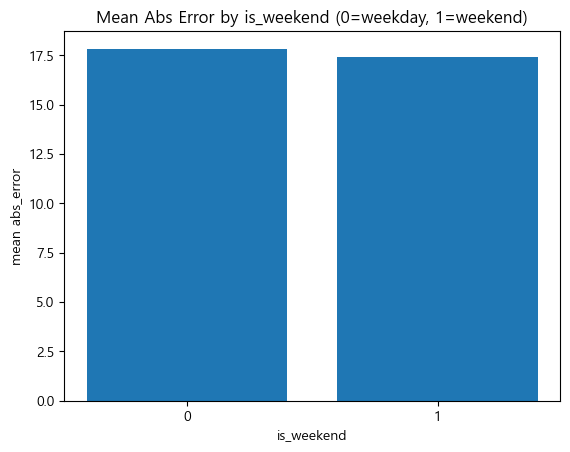


📌 [공항명] 평균 절대오차 상위 TOP 15


,mean_abs_error
공항명,
양양,36.015011
청주,26.125381
인천,18.500120
광주,18.238358
군산,18.119837
김해,17.222301
여수,16.941536
제주,16.359600
대구,16.256355


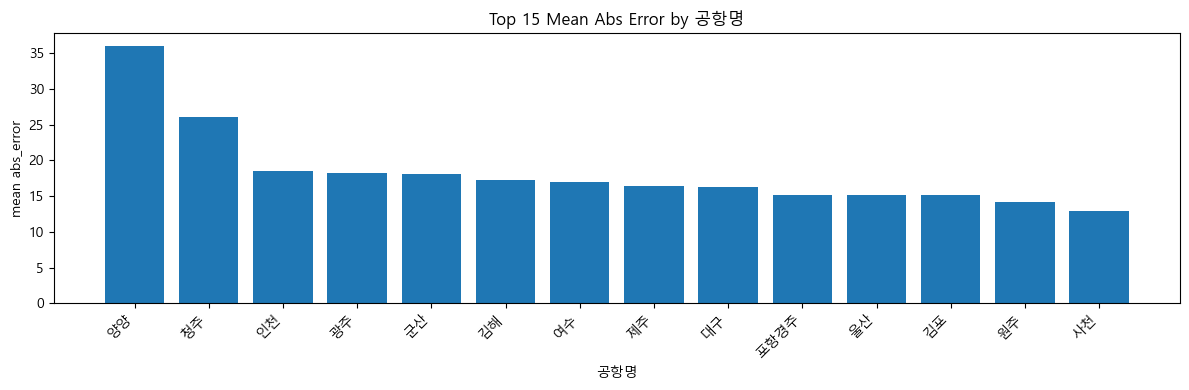


📌 [출발지] 평균 절대오차 상위 TOP 15


,mean_abs_error
출발지,
양양,36.015011
청주,26.125381
인천,18.500120
광주,18.238358
군산,18.119837
김해,17.222301
여수,16.941536
제주,16.359600
대구,16.256355


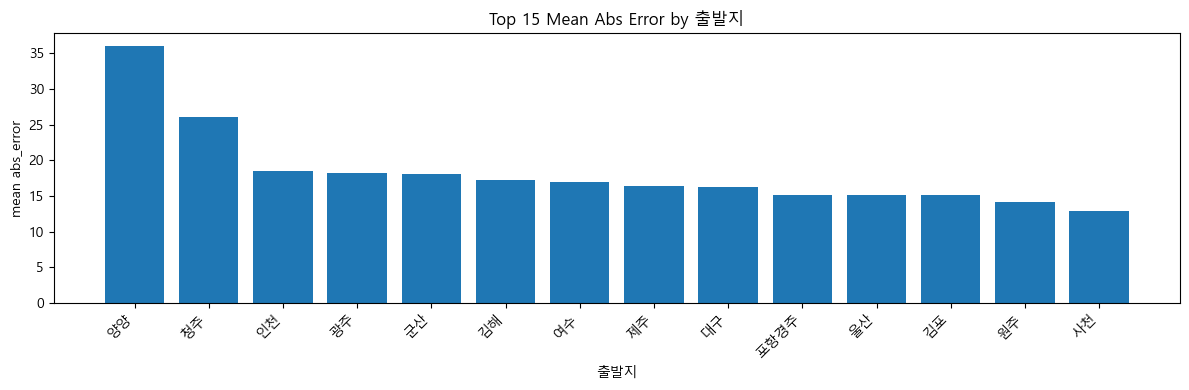


📌 [도착지] 평균 절대오차 상위 TOP 15


,mean_abs_error
도착지,
화롄,145.047028
테트보로,131.197571
오산,120.316437
아시가바트,119.801254
알아인,113.711967
하코다테,106.042320
고베,100.021675
우이산,92.182770
앵커리지,88.531013


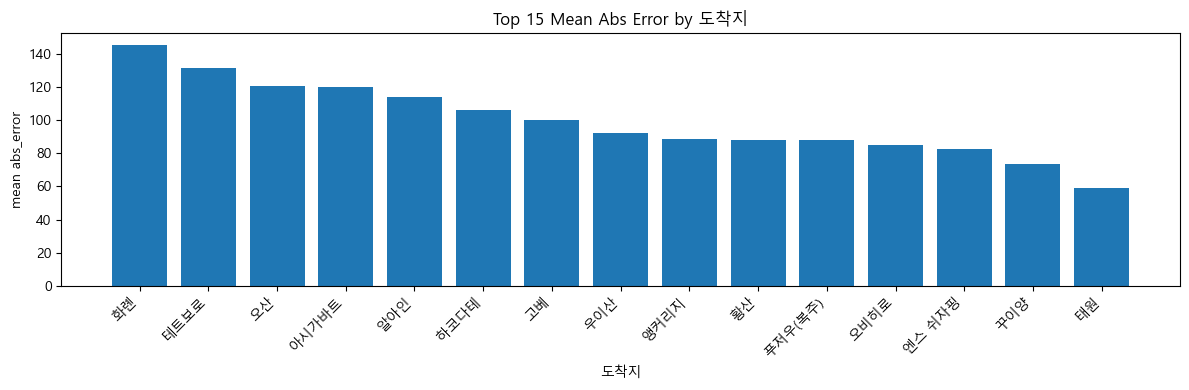


📌 [flight_type] 평균 절대오차 상위 TOP 15


,mean_abs_error
flight_type,
국제,18.888708
국내,15.824018


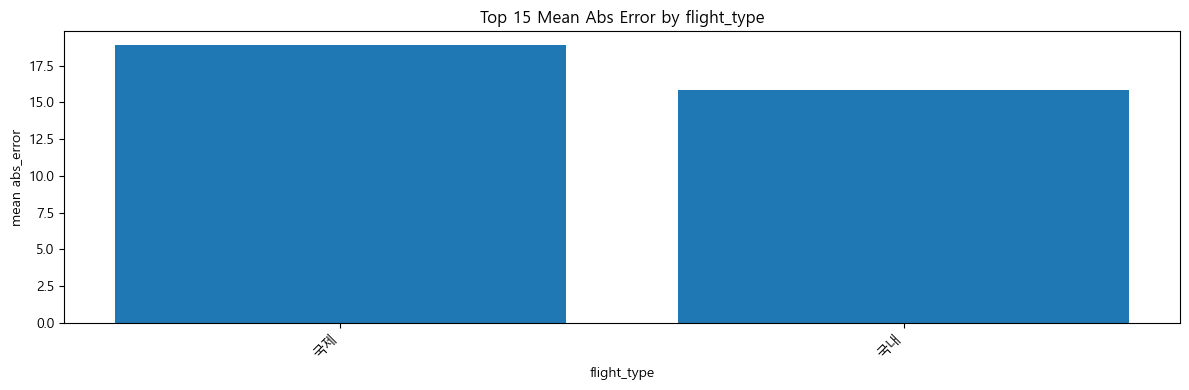

In [16]:
# =====================================================
# ✅ (추가) 1️⃣2️⃣-A 시각화: 결과 요약표 + 오차(에러) 분석 그래프
# -----------------------------------------------------
# 목적
# 1) 모델 성능을 '표'로 한눈에 확인 (MAE / RMSE / R2 / MAPE 등)
# 2) 예측이 어디에서 많이 틀리는지 '그래프'로 확인
#    - 오차 분포(히스토그램)
#    - 실제값 구간(quantile)별 절대오차(boxplot)
#    - 큰 지연에서 과소/과대 예측하는지(Actual vs Error)
# 3) (가능하면) 시간/요일/카테고리(공항/출발/도착/국내/국제)별 평균 오차 비교
#
# ⚠️ 주의 (속도/메모리)
# - 데이터가 매우 크면 산점도/히스토그램이 무거울 수 있어 샘플링을 적용합니다.
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 0) 필수 변수 점검
# -----------------------------
# y_test_np: 테스트 타겟(실제 지연_분)
# y_pred   : 테스트 예측값 (위 "시각화 실행 안정화" 셀에서 통일)
assert "y_test_np" in globals(), "❌ y_test_np 가 없습니다. 먼저 전처리/학습 셀을 실행하세요."
assert "y_pred" in globals(),     "❌ y_pred 가 없습니다. '시각화 실행 안정화' 셀을 실행하거나 예측을 만든 뒤 진행하세요."

y_true = np.asarray(y_test_np).reshape(-1)
y_hat  = np.asarray(y_pred).reshape(-1)

# -----------------------------
# 1) 결과 DataFrame 만들기 (표/그래프 공통 재료)
# -----------------------------
viz_df = pd.DataFrame({
    "actual_delay_min": y_true,
    "pred_delay_min":   y_hat
})
# 오차(예측 - 실제)
viz_df["error"] = viz_df["pred_delay_min"] - viz_df["actual_delay_min"]
viz_df["abs_error"] = np.abs(viz_df["error"])

# (옵션) 음수 예측이 있으면 확인
neg_pred_cnt = int((viz_df["pred_delay_min"] < 0).sum())
print(f"🔎 음수 예측 개수: {neg_pred_cnt:,} / {len(viz_df):,}")

# -----------------------------
# 2) 성능 요약표 (표)
# -----------------------------
# MAE: 평균 절대 오차
# RMSE: 큰 오차에 더 민감(제곱)
# R2: 1에 가까울수록 설명력 좋음
mae  = mean_absolute_error(viz_df["actual_delay_min"], viz_df["pred_delay_min"])
rmse = np.sqrt(mean_squared_error(viz_df["actual_delay_min"], viz_df["pred_delay_min"]))
r2   = r2_score(viz_df["actual_delay_min"], viz_df["pred_delay_min"])

# MAPE: 실제값이 0에 가까우면 폭발할 수 있어 작은 값은 제외하거나 eps를 둡니다.
eps = 1e-6
mape = (np.abs(viz_df["error"]) / (np.abs(viz_df["actual_delay_min"]) + eps)).mean() * 100

summary_df = pd.DataFrame({
    "metric": ["MAE", "RMSE", "R2", "MAPE(%)"],
    "value":  [mae, rmse, r2, mape]
})

# ✅ Jupyter에서 보기 좋게 출력
try:
    from IPython.display import display
    display(summary_df)
except Exception:
    print(summary_df)

# -----------------------------
# 3) 큰 오차 TOP-N 표 (어디서 크게 틀렸는지)
# -----------------------------
TOP_N = 20
top_err_df = viz_df.sort_values("abs_error", ascending=False).head(TOP_N).copy()

# (가능하면) 원본 피처(X_test)가 있으면 같이 붙여서 "어떤 상황에서 틀렸는지" 바로 확인
if "X_test" in globals() and isinstance(X_test, pd.DataFrame):
    # 인덱스 정렬: X_test / y_test는 동일 인덱스로 만들어졌으므로 그대로 결합 가능
    tmp_feat = X_test.copy()
    tmp_feat = tmp_feat.loc[y_test.index].reset_index(drop=True)
    top_err_df = top_err_df.reset_index(drop=True)
    # 행 수가 같아야 안전
    if len(tmp_feat) == len(viz_df):
        viz_with_feat = pd.concat([tmp_feat, viz_df.reset_index(drop=True)], axis=1)
        top_err_df = viz_with_feat.sort_values("abs_error", ascending=False).head(TOP_N).copy()

print(f"📌 절대오차 TOP {TOP_N} 샘플")
try:
    display(top_err_df)
except Exception:
    print(top_err_df)

# -----------------------------
# 4) 그래프용 샘플링 (데이터가 매우 크면 plot이 너무 무거움)
# -----------------------------
MAX_PLOT_POINTS = 50000  # 산점도/분포 그래프에 사용할 최대 포인트 수
if len(viz_df) > MAX_PLOT_POINTS:
    plot_df = viz_df.sample(MAX_PLOT_POINTS, random_state=42)
    print(f"⚙️ plot_df 샘플링 적용: {len(viz_df):,} -> {len(plot_df):,}")
else:
    plot_df = viz_df

# -----------------------------
# 5) 오차 분포 (error histogram)
# -----------------------------
plt.figure()
plt.hist(plot_df["error"], bins=60)
plt.axvline(0, linestyle="--")
plt.title("Error Distribution (pred - actual)")
plt.xlabel("error (min)")
plt.ylabel("count")
plt.show()

# -----------------------------
# 6) 절대오차 분포 (abs_error histogram)
# -----------------------------
plt.figure()
plt.hist(plot_df["abs_error"], bins=60)
plt.title("Absolute Error Distribution |pred - actual|")
plt.xlabel("abs_error (min)")
plt.ylabel("count")
plt.show()

# -----------------------------
# 7) 실제 지연시간 구간(분위수)별 절대오차 Boxplot
# -----------------------------
# "큰 지연" 영역에서 특히 틀리는지 확인하기 좋습니다.
try:
    # q=10: 10개 분위수 구간(데이터가 부족하면 자동으로 줄어듦)
    q_bins = pd.qcut(viz_df["actual_delay_min"], q=10, duplicates="drop")
    # boxplot은 구간 순서대로 데이터 리스트를 만들어야 합니다.
    cats = q_bins.cat.categories
    box_data = [viz_df.loc[q_bins == cat, "abs_error"].values for cat in cats]

    plt.figure(figsize=(12, 5))
    plt.boxplot(box_data, showfliers=False)
    # x축 레이블을 너무 길지 않게 "구간 시작~끝"으로 표시
    labels = [f"{int(iv.left)}~{int(iv.right)}" for iv in cats]
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha="right")
    plt.title("Abs Error by Actual Delay Quantiles")
    plt.xlabel("actual_delay_min (quantile bins)")
    plt.ylabel("abs_error (min)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("⚠️ 분위수 구간 boxplot을 만들지 못했습니다:", e)

# -----------------------------
# 8) 실제값 vs 오차 산점도 (패턴 확인)
# -----------------------------
# - 실제가 커질수록 과소예측(음수 error)이 늘어나는지?
# - 특정 구간에서 과대/과소가 치우치는지?
plt.figure()
plt.scatter(plot_df["actual_delay_min"], plot_df["error"], alpha=0.2)
plt.axhline(0, linestyle="--")
plt.title("Actual vs Error (pattern check)")
plt.xlabel("actual_delay_min")
plt.ylabel("error (pred - actual)")
plt.show()

# -----------------------------
# 9) 실제/예측 분포 비교 (히스토그램 2개)
# -----------------------------
plt.figure()
plt.hist(plot_df["actual_delay_min"], bins=60, alpha=0.5, label="actual")
plt.hist(plot_df["pred_delay_min"],   bins=60, alpha=0.5, label="pred")
plt.title("Distribution Compare: actual vs pred")
plt.xlabel("delay_min")
plt.ylabel("count")
plt.legend()
plt.show()

# -----------------------------
# 10) 시간/요일/주말별 평균 오차 (가능할 때만)
# -----------------------------
# 여기부터는 X_test가 있을 때만 실행합니다.
if "X_test" in globals() and isinstance(X_test, pd.DataFrame):
    eval_df = X_test.loc[y_test.index].copy().reset_index(drop=True)
    eval_df["actual_delay_min"] = y_true
    eval_df["pred_delay_min"]   = y_hat
    eval_df["abs_error"]        = np.abs(eval_df["pred_delay_min"] - eval_df["actual_delay_min"])

    # (A) 출발 시간대(dep_hour)별 평균 절대오차
    if "dep_hour" in eval_df.columns:
        by_hour = eval_df.groupby("dep_hour")["abs_error"].mean().sort_index()
        try:
            display(by_hour.to_frame("mean_abs_error"))
        except Exception:
            print(by_hour)

        plt.figure()
        plt.plot(by_hour.index, by_hour.values, marker="o")
        plt.title("Mean Abs Error by dep_hour")
        plt.xlabel("dep_hour")
        plt.ylabel("mean abs_error")
        plt.xticks(by_hour.index)
        plt.show()

    # (B) 요일(dep_weekday)별 평균 절대오차
    if "dep_weekday" in eval_df.columns:
        by_wd = eval_df.groupby("dep_weekday")["abs_error"].mean().sort_index()
        try:
            display(by_wd.to_frame("mean_abs_error"))
        except Exception:
            print(by_wd)

        plt.figure()
        plt.plot(by_wd.index, by_wd.values, marker="o")
        plt.title("Mean Abs Error by dep_weekday (0=Mon ... 6=Sun)")
        plt.xlabel("dep_weekday")
        plt.ylabel("mean abs_error")
        plt.xticks(by_wd.index)
        plt.show()

    # (C) 주말(is_weekend)별 평균 절대오차
    if "is_weekend" in eval_df.columns:
        by_weekend = eval_df.groupby("is_weekend")["abs_error"].mean()
        try:
            display(by_weekend.to_frame("mean_abs_error"))
        except Exception:
            print(by_weekend)

        plt.figure()
        plt.bar(by_weekend.index.astype(str), by_weekend.values)
        plt.title("Mean Abs Error by is_weekend (0=weekday, 1=weekend)")
        plt.xlabel("is_weekend")
        plt.ylabel("mean abs_error")
        plt.show()

    # (D) 카테고리 변수별(공항/출발/도착/국내/국제) TOP-K 평균 오차
    cat_candidates = ["공항명", "출발지", "도착지", "flight_type"]
    TOP_K = 15

    for cat in cat_candidates:
        if cat in eval_df.columns:
            grp = eval_df.groupby(cat)["abs_error"].mean().sort_values(ascending=False).head(TOP_K)
            print(f"\n📌 [{cat}] 평균 절대오차 상위 TOP {TOP_K}")
            try:
                display(grp.to_frame("mean_abs_error"))
            except Exception:
                print(grp)

            # 막대 그래프 (카테고리명이 길면 회전)
            plt.figure(figsize=(12, 4))
            plt.bar(grp.index.astype(str), grp.values)
            plt.title(f"Top {TOP_K} Mean Abs Error by {cat}")
            plt.xlabel(cat)
            plt.ylabel("mean abs_error")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
else:
    print("ℹ️ X_test(DataFrame)가 없어서 시간/카테고리별 분석 그래프는 생략합니다.")

In [17]:
# =====================================================
# 1️⃣3️⃣ 예측 결과 확인
# =====================================================
result_df = pd.DataFrame({
    "actual_delay": y_test.values,
    "predicted_delay": y_pred
})

result_df.head(20)

,actual_delay,predicted_delay
0,37.0,46.890369
1,56.0,92.229927
2,40.0,56.764065
3,38.0,56.764065
4,9.0,42.704803
5,37.0,43.004871
6,70.0,43.004871
7,30.0,37.652344
8,146.0,67.414207
9,73.0,48.041332
